<a id='main' name="main"></a>
# Viral Data Analysis

Date: 2021.~09.10~

Author: © 2021 ~Skirmantas Navickas~ 

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from [Our World in Data](https://ourworldindata.org/) to answer the following questions:

1. ~[Compare average daily deaths in Europe's top 5 countries by GDP per person to Lowest 5](#Q1)~
1. ~[How does the stringency index correlate with daily new cases and new hospitalizations in Lithuania, Latvia, Estonia](#Q2)~
1. ~[Can we predict Lithuania's future stringency index based on, daily new cases, daily deaths, and new hospitalizations historical data.](#Q3)~


This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

~[First question conclusion](#Q1Conclusion)~ <br>
~[Second question conclusion](#Q2Conclusion)~ <br>
~[Third question conclusion](#Q3Conclusion)~ <br>


## Load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from matplotlib.pyplot import figure

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [2]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

33716955

Load the file to Pandas.

In [3]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

Check the columns available.

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. Compare death rate Europes in top 5 countries by GDP per person to Lowest 5~? 


Firstly we select only required columns for this questions. <br>
I use <u>new cases smoothed per million</u> over <u>new cases per million</u> since it removes most data inconsistancies due to contries reporting <br>
After that we just find countries with with lowest GDP per person and highest GDP per person



In [4]:
europe_df = df[df['continent'] == 'Europe'][['iso_code', 'location', 'gdp_per_capita', 'date', 'new_cases_smoothed_per_million']]
europe_df['new_cases_smoothed_per_million'] = europe_df['new_cases_smoothed_per_million'].fillna(0)

europe_gdp = europe_df.groupby('location').mean()['gdp_per_capita'].dropna(inplace=False)

europe_smallest_gdp = europe_gdp.nsmallest(n=5, keep='first')
smallest_gdp_locations = europe_smallest_gdp.index.array

europe_largest_gdp = europe_gdp.nlargest(n=5, keep='first')
largest_gdp_locations = europe_largest_gdp.index.array

print(smallest_gdp_locations)
print(largest_gdp_locations)


<PandasArray>
['Moldova', 'Ukraine', 'Kosovo', 'Bosnia and Herzegovina', 'Albania']
Length: 5, dtype: object
<PandasArray>
['Luxembourg', 'Ireland', 'Norway', 'Switzerland', 'San Marino']
Length: 5, dtype: object


So we found our countries. <br>
In the top 5 countries we have:
1. Luxembourg
1. Ireland
1. Norway
1. Switzerland
1. San Marino
<br>


And in the bottom 5:
1. Moldova
1. Ukraine
1. Kosovo
1. Bosnia and Herzegovina
1. Albania

My assumption would be, that countries with different financial powers could react to covid infections in more efficient ways. So lets plot some data and see how it shapes up. <br>
<b>Note:</b> the charts for this question are set to the same scale, so visual comparison would be easier.


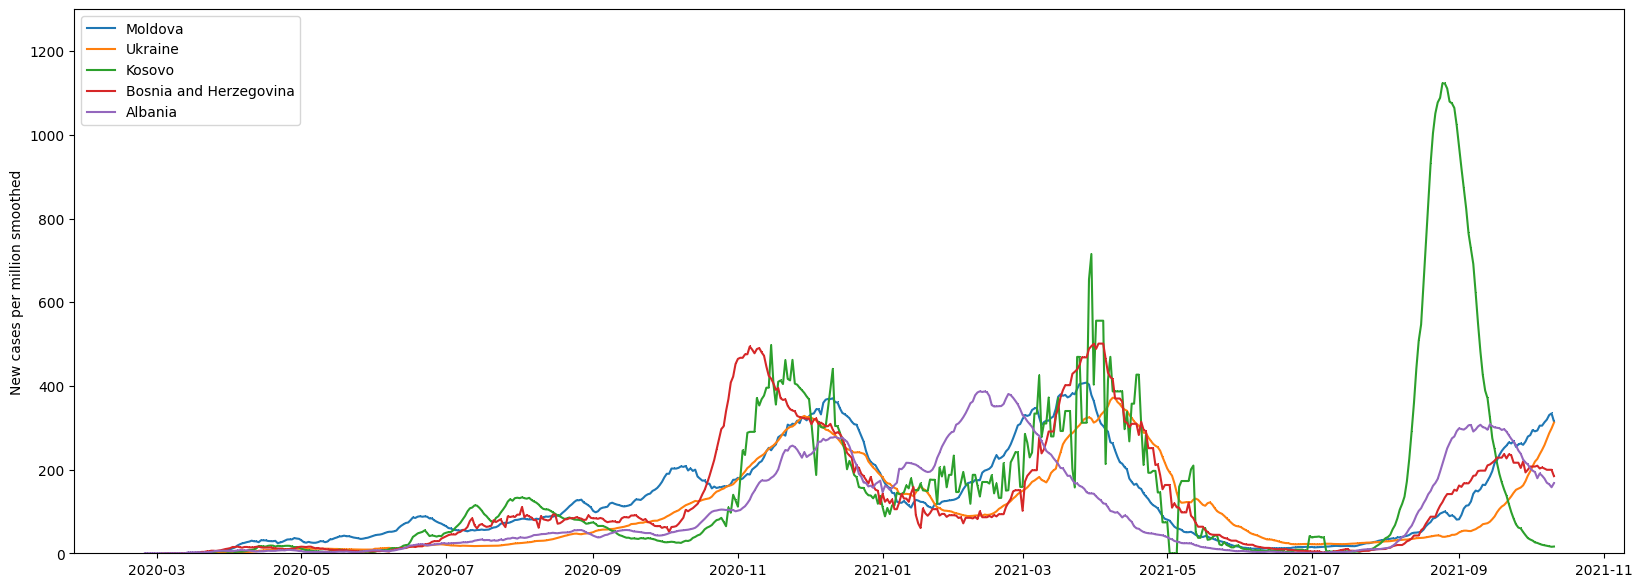

In [25]:
figure(figsize=(20, 8), dpi=100)
plt.gcf().autofmt_xdate()

for location in smallest_gdp_locations:
    filtered = europe_df[europe_df['location'] == location].sort_values(by='date')
    plt.plot_date(filtered['date'], filtered['new_cases_smoothed_per_million'], label=location, linestyle='-', marker=',')
    
axes = plt.gca()
axes.set_ylim([0, 1300])
axes.set_ylabel('New cases per million smoothed')
plt.legend()
plt.show()

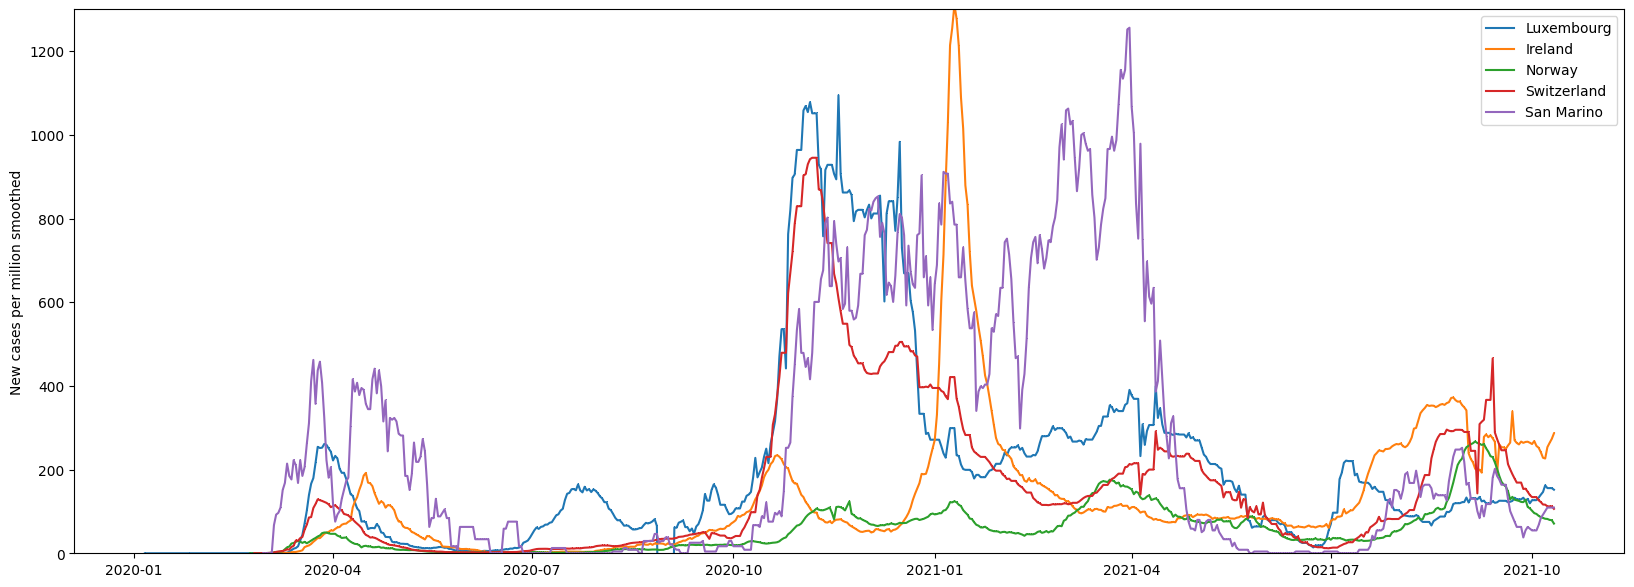

In [24]:
figure(figsize=(20, 8), dpi=100)
plt.gcf().autofmt_xdate()

for location in largest_gdp_locations:
    filtered = europe_df[europe_df['location'] == location].sort_values(by='date')
    plt.plot_date(filtered['date'], filtered['new_cases_smoothed_per_million'], label=location, linestyle='-', marker=',')

axes = plt.gca()
axes.set_ylim([0, 1300])
axes.set_ylabel('New cases per million smoothed')
plt.legend()
plt.show()

If we were to plot all the countries lines on one chart, it would be very messy and would not grant much information. <br>
Since we are not comparing each country individualy, but the top and bottom 5, we can calculate their averages per day and plot that. <br>


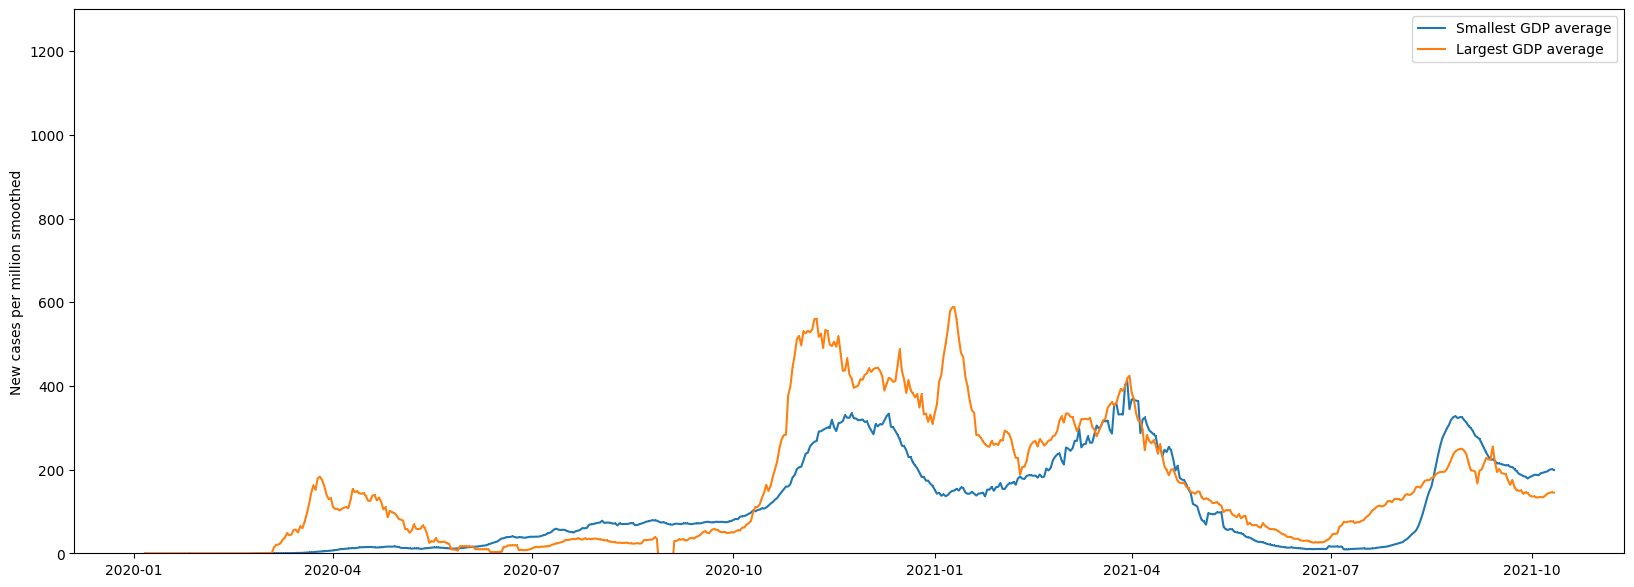

In [28]:
df_smallest_gdp = europe_df[europe_df['location'].isin(smallest_gdp_locations)]
df_largest_gdp = europe_df[europe_df['location'].isin(largest_gdp_locations)]

smallest_average_cases = df_smallest_gdp.groupby('date').mean('new_cases_smoothed_per_million')
largest_average_cases = df_largest_gdp.groupby('date').mean('new_cases_smoothed_per_million')

figure(figsize=(20, 8), dpi=100)
plt.gcf().autofmt_xdate()

plt.plot_date(smallest_average_cases.index, smallest_average_cases['new_cases_smoothed_per_million'], label='Smallest GDP average', linestyle='-', marker=',')
plt.plot_date(largest_average_cases.index, largest_average_cases['new_cases_smoothed_per_million'], label='Largest GDP average', linestyle='-', marker=',')

axes = plt.gca()
axes.set_ylim([0, 1300])
axes.set_ylabel('New cases per million smoothed')
plt.legend()
plt.show()


Just for fun, lets plot the difference of both curves from the previous graph. This would make it a bit easier to evaluate the differences. The red line indicates 0 (no difference). Negative values mean countries with higher GDP had more cases

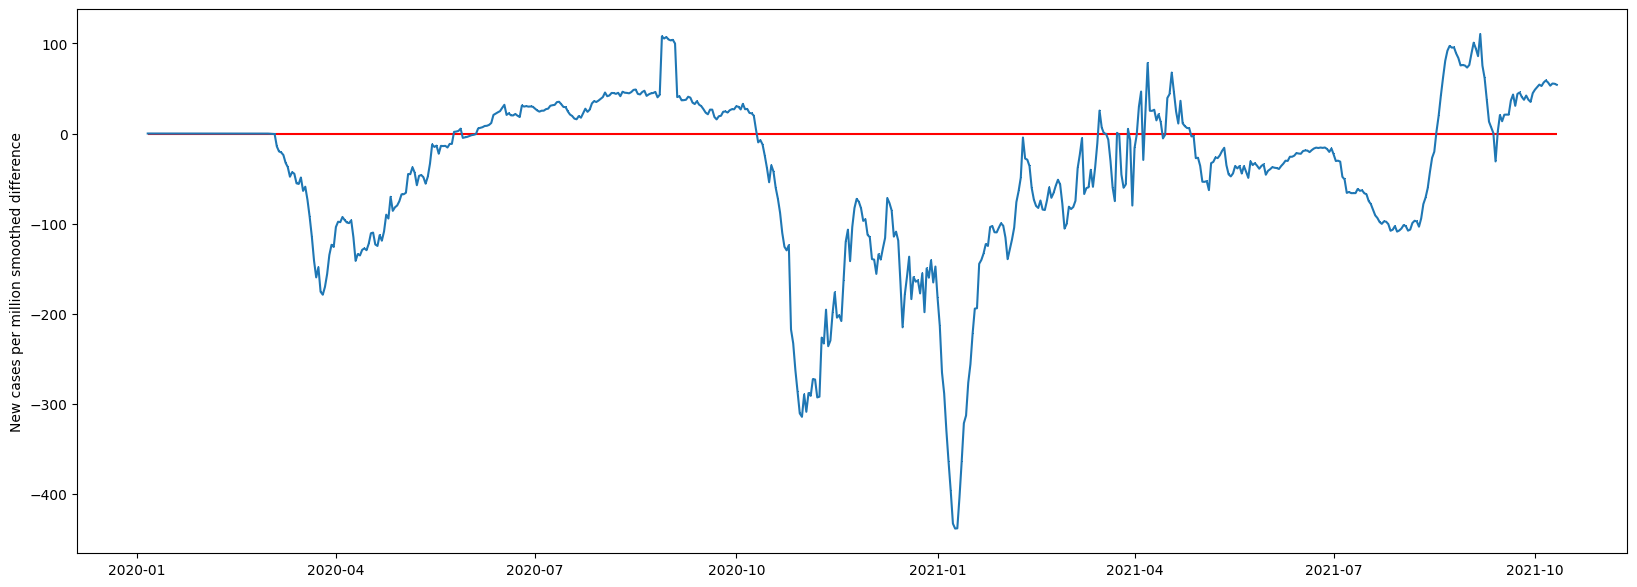

In [32]:
diff = smallest_average_cases['new_cases_smoothed_per_million'] - largest_average_cases['new_cases_smoothed_per_million']
diff.sort_index(inplace=True)
diff.fillna(0, inplace=True)

figure(figsize=(20, 8), dpi=100)
plt.gcf().autofmt_xdate()

plt.plot_date(diff.index, diff, linestyle='-', marker=',')
# plt.plot_date(largest_average_cases.index, largest_average_cases['new_cases_smoothed_per_million'], label='Largest GDP average', linestyle='-', marker=',')

axes = plt.gca()
axes.set_ylabel('New cases per million smoothed difference')
plt.hlines(0, diff.index.min(), diff.index.max(), colors='red')
plt.show()

<a id='Q1Conclusion' name='Q1Conclusion'></a>
## Conclusion

It seems no discernible pattern from this comparison can be derived. It seems that both rich and poor countries had similar difficulties, with the rich countries strugling more on average. <br>
I expected rich countries to be more well off on average, but this data is still interesting and I have several hypothesis why we don't see any major differences:
1. Rich countries have better evolved infrastructures, that can make containement more diffucult
1. Poor countries could possibly not have the testing capacity to properly determine their own cases.
1. Rich countries have more transits between other countries, witch would impact their initial case growth (looking at 2020-03 / 2020-07)

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. ~How does the stringency index correlate with daily new cases in Lithuania, Latvia, Estonia~? 

Stringency index is a very interesting parameter. Countries are scored from 0 to 100 depending on how harsh their response is (0 is no response, 100 maximum close-down) <br>
It's calculated from 9 parameters:
1. school closures
1. workplace closures
1. cancellation of public events
1. restrictions on public gatherings
1. closures of public transport
1. stay-at-home requirements
1. public information campaigns
1. restrictions on internal movements
1. international travel controls


In a perfect world, this index would be very closely correlated to how the pandemic is progresing, but in reality we should expect that various politics play a major part in determening the stringency of the response. <br>
With this question, if we see a low correlation between various countries parameters and their stringency we should be able to claim that politics played a major part. <br>
<b>Note:</b> Some countries had very low stringency indexies and had decenet handling of the pandemic. It's not directly a parameter on how well is the country with the pandemic, but for a stringent country it would at least show how seriously the pandemic is being taken.

For the mentioned points, one could claim that parameters like <b>daily new cases smoothed</b>.


First of all, since the <b>stringency index</b> is filled in retrospectively, we need a method to cutoff the latest data to remove noise. 30 days seems to be a good cutoff value.

In [33]:
def cutoff_latest(data_frame: pd.DataFrame):
    max_date = data_frame['date'].max()
    cutoff_date = max_date - datetime.timedelta(days=30)
    return data_frame[data_frame['date'] < cutoff_date]

Firstly, we load all the required data, do the cutoff and fill in NAN values with zeroes, since if stringency index is not filled in we can claim the country has not begun their response yet.
Then we plot graphs for both <b>stringency index</b> in selected countries and <b>daily new cases smoothed</b> for visual comparison. <br>
<b>Note:</b> The red line in both graphs indicate the first authorized usage of a vaccine in the EU

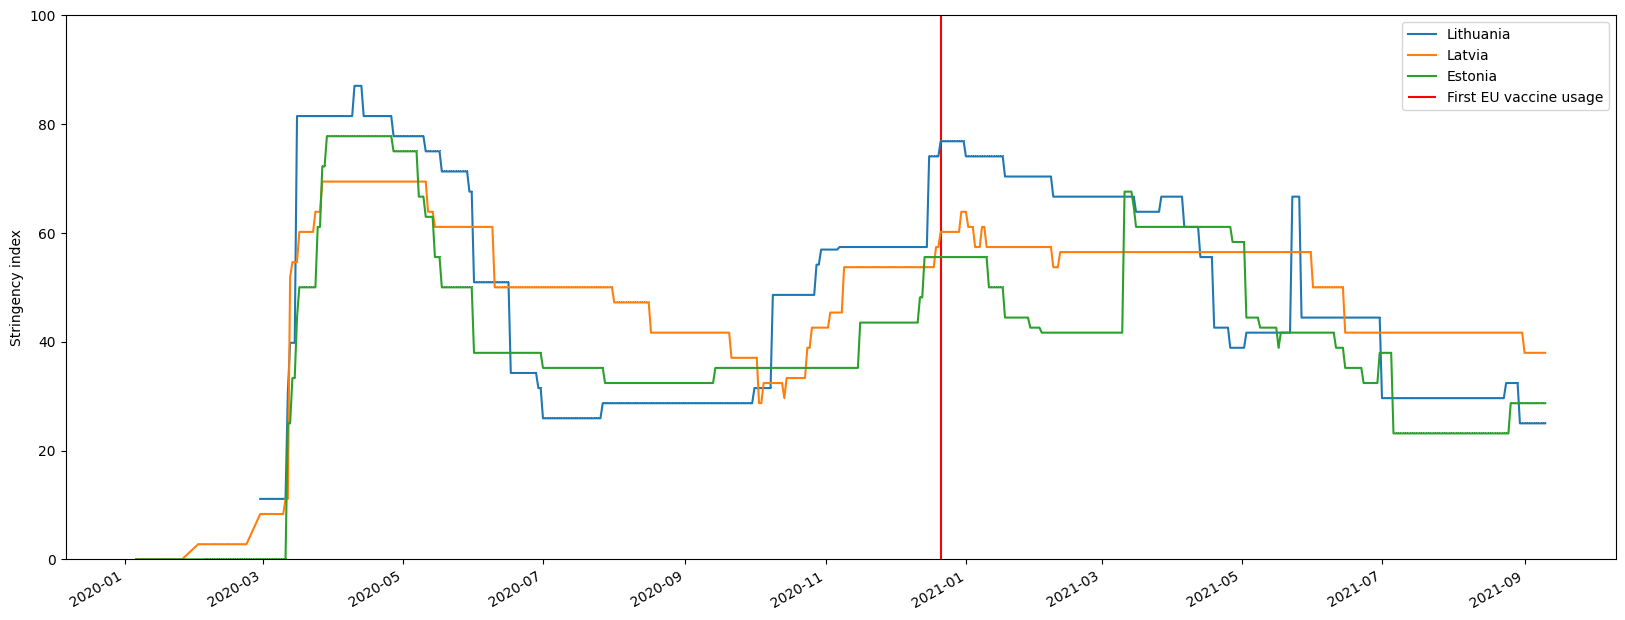

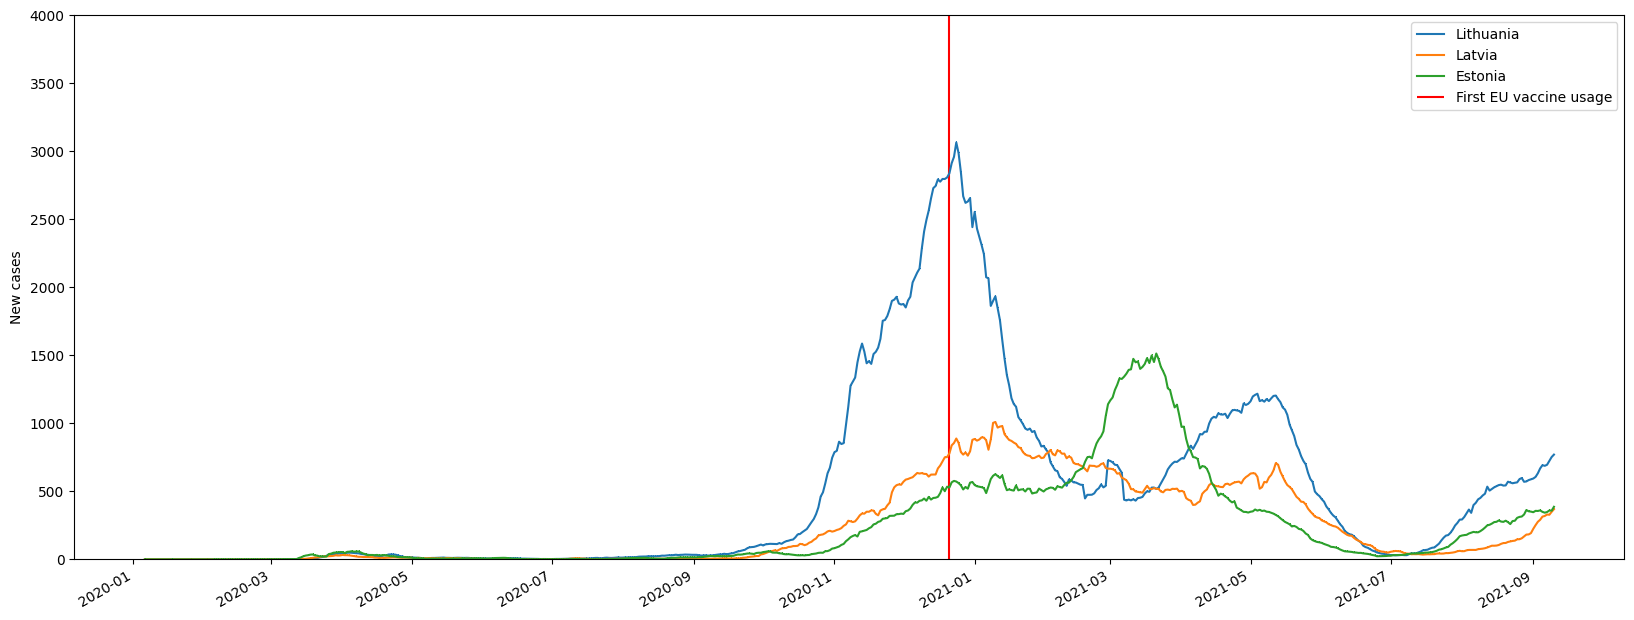

In [35]:
columns_to_select = ['date', 'new_cases_smoothed', 'stringency_index', 'location']
countries_to_select = ['Lithuania', 'Latvia', 'Estonia']

stringency_df = df[columns_to_select]
stringency_df = stringency_df[stringency_df['location'].isin(countries_to_select)]
stringency_df['new_cases_smoothed'] = stringency_df['new_cases_smoothed'].fillna(0)
stringency_df['stringency_index'] = stringency_df['stringency_index'].fillna(0)

#filtering latest dates since stringency_index is not filled for them 
stringency_df = cutoff_latest(stringency_df)

figure(figsize=(20, 8), dpi=100)
for country in countries_to_select:
    plt.gcf().autofmt_xdate()
    filtered = stringency_df[stringency_df['location'] == country].sort_values(by='date')
    plt.plot_date(filtered['date'], filtered['stringency_index'], label=country, linestyle='-', marker=',')
    
axes = plt.gca()
axes.set_ylim([0, 100])
plt.vlines(datetime.date(2020, 12, 21), ymin=0, ymax=100, label='First EU vaccine usage', colors='red')
axes.set_ylabel('Stringency index')
plt.legend()
plt.show()

figure(figsize=(20, 8), dpi=100)
for country in countries_to_select:
    plt.gcf().autofmt_xdate()
    filtered = stringency_df[stringency_df['location'] == country].sort_values(by='date')
    plt.plot_date(filtered['date'], filtered['new_cases_smoothed'], label=country, linestyle='-', marker=',')
    
axes = plt.gca()
plt.vlines(datetime.date(2020, 12, 21), ymin=0, ymax=4000, label='First EU vaccine usage', colors='red')
axes.set_ylim([0, 4000])
axes.set_ylabel('New cases')
plt.legend()
plt.show()


Visualy it seems there is not much correlation between <b>stringency index</b>. Especially in the begining of the pandemic, where the <b>daily cases</b> were low, but the stringency index was high (around 2020-03). I will discuss the implication of that in the conclusion, but first, let's calculate the correlation between these parameters, since visual analysis can be inacurate.

In [36]:
for country in countries_to_select:
    filtered = stringency_df[stringency_df['location'] == country]
    corr = filtered['new_cases_smoothed'].corr(filtered['stringency_index'])
    print(f'Correlation between new cases and stringency index in {country} is: {corr}')

Correlation between new cases and stringency index in Lithuania is: 0.33867502243423925
Correlation between new cases and stringency index in Latvia is: 0.33475625996042224
Correlation between new cases and stringency index in Estonia is: 0.3276972401499441


<a id='Q2Conclusion' name='Q2Conclusion'></a>
## Conclusion

Correlation for all the selected countries seems to be weak. Like mentioned before, this shows how a countries response harshness is definetly affected not only defined by the actuall situation of the pandemic but by other factors as well like:
1. Politics intention, and possible hope of being the leaders that saved the nation from a pandemic
1. Peoples fear of the pandemic
1. Peoples reluctance to be restricted by what can they do
1. In the begining (around 2020-03) lack of knowledge for experts on what response would be adequate, and suggesting a restrictive response just to be on the safe side

<b>Possible improvement:</b> If one would collect the sentiment about SARS-COV-2 from news outlets and see the corelation of that with stringency index.

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. ~Can we predict Lithuania's future stringency index based on, daily new cases, daily deaths, and new hospitalizations historical data.~? 

This question is like an extenstion to the second question. We try to test how numbers based a countries decision on lockdowns are, using ML algorithims and historical data <br>

For the same task i will use 3 different ML models:
1. <b>AutoReg</b> provided by <b>StatsModels</b>
2. <b>Random forrest</b> provided by <b>SKlearn</b>
3. <b>LinearSVR</b> provided by <b>SKlearn</b>

For the <b>AutoReg</b> i will do more experimantation with various parameters, while the rest are simple implementations for pure comparison

In [39]:
from statsmodels.tsa.ar_model import AutoReg
import itertools

Some helper function to split data set or calculate the MSE

In [40]:
def train_test_split(df, ratio=0.8):
    row_count = len(df)
    split_index = int(row_count * ratio)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    return train_df, test_df

def calc_mse(pred, actual):
    mse = 0
    for i, val in enumerate(pred):
        mse += (val - actual[i]) ** 2
    mse = mse / len(pred)
    return mse


For now lets assume that all used feature values where they are NAN are equal to 0. Later on i will try droping the rows with NAN value and compare the results.

In [86]:
filtered_df = df[df['location'] == 'Lithuania'][['date', 'location', 'stringency_index', 'new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']].sort_values('date', ascending=True)
filtered_df = cutoff_latest(filtered_df)
filtered_df['new_cases_smoothed'] = filtered_df['new_cases_smoothed'].fillna(0)
filtered_df['reproduction_rate'] = filtered_df['reproduction_rate'].fillna(0)
filtered_df['hosp_patients'] = filtered_df['hosp_patients'].fillna(0)
filtered_df['new_deaths_smoothed'] = filtered_df['new_deaths_smoothed'].fillna(0)


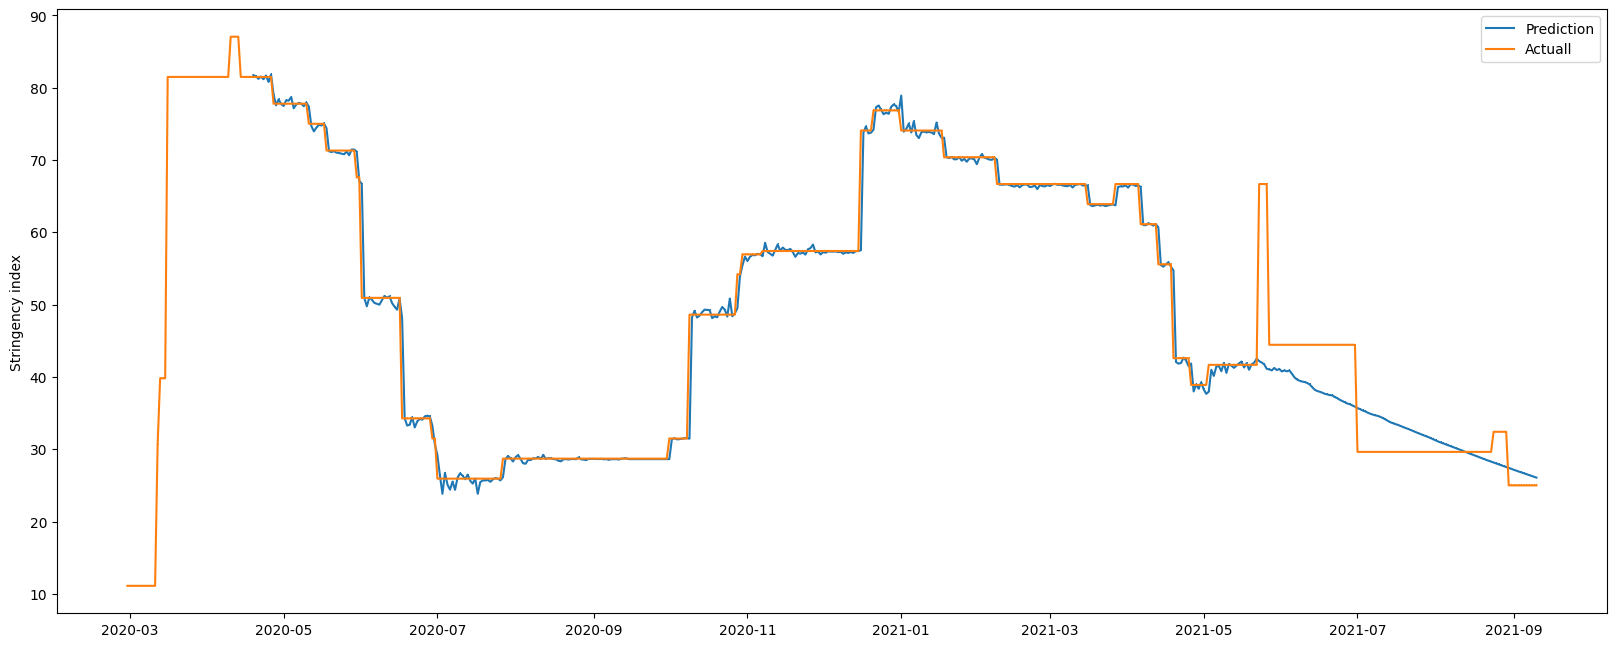

Training mse: 3.6726008216503288 
Test mse: 39.702053211958265


In [87]:
lag = 50
train_df, test_df = train_test_split(filtered_df)
res = AutoReg(train_df['stringency_index'], lags=lag, trend='n').fit()
pred = res.predict(end=len(train_df)+len(test_df)-1)

figure(figsize=(20, 8), dpi=100)

plt.plot_date(filtered_df['date'], pred, label='Prediction',linestyle='-', marker=',')
plt.plot_date(filtered_df['date'], filtered_df['stringency_index'], label='Actuall', linestyle='-', marker=',')
axes = plt.gca()
axes.set_ylabel('Stringency index')
plt.legend()
plt.show()

train_mse = calc_mse(pred[lag:len(train_df)], train_df['stringency_index'].to_numpy()[lag:])
test_mse = calc_mse(pred[len(train_df):], test_df['stringency_index'].to_numpy())

print(f'Training mse: {train_mse} \nTest mse: {test_mse}')

It seems that having only one parameter pretty much creates a trend line, and that is not quite accurate. More parameters should remove this rigidity. One interesting observation: with this model, setting <b>LAG</b> to higher values, causes more variance in the training. 

C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


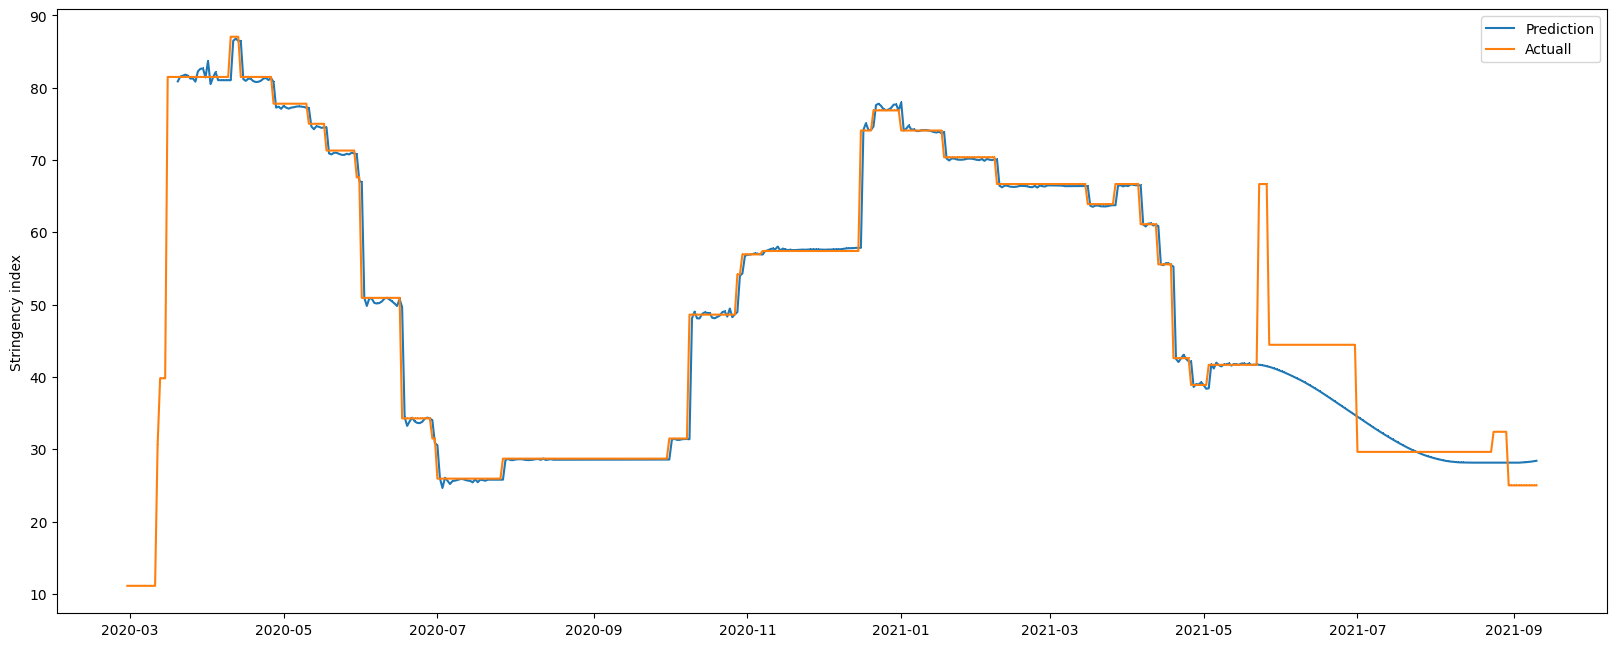

Training mse: 3.6856582211886684 
Test mse: 39.12801021144891


In [70]:
lag = 20
res = AutoReg(train_df['stringency_index'], lags=lag, exog=train_df[['new_cases_smoothed', 'new_deaths_smoothed']], trend='n').fit()
pred = res.predict(end=len(train_df)+len(test_df)-1, exog=train_df[['new_cases_smoothed', 'new_deaths_smoothed']], exog_oos=test_df[['new_cases_smoothed', 'new_deaths_smoothed']])

figure(figsize=(20, 8), dpi=100)

plt.plot_date(filtered_df['date'], pred, label='Prediction',linestyle='-', marker=',')
plt.plot_date(filtered_df['date'], filtered_df['stringency_index'], label='Actuall', linestyle='-', marker=',')
axes = plt.gca()
axes.set_ylabel('Stringency index')
plt.legend()
plt.show()

train_mse = calc_mse(pred[lag:len(train_df)], train_df['stringency_index'].to_numpy()[lag:])
test_mse = calc_mse(pred[len(train_df):], test_df['stringency_index'].to_numpy())
axes.set_ylabel('Stringency index')
print(f'Training mse: {train_mse} \nTest mse: {test_mse}')

As expected, with more parameters, the prediction start to look more like a curve and less like a line. 

C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


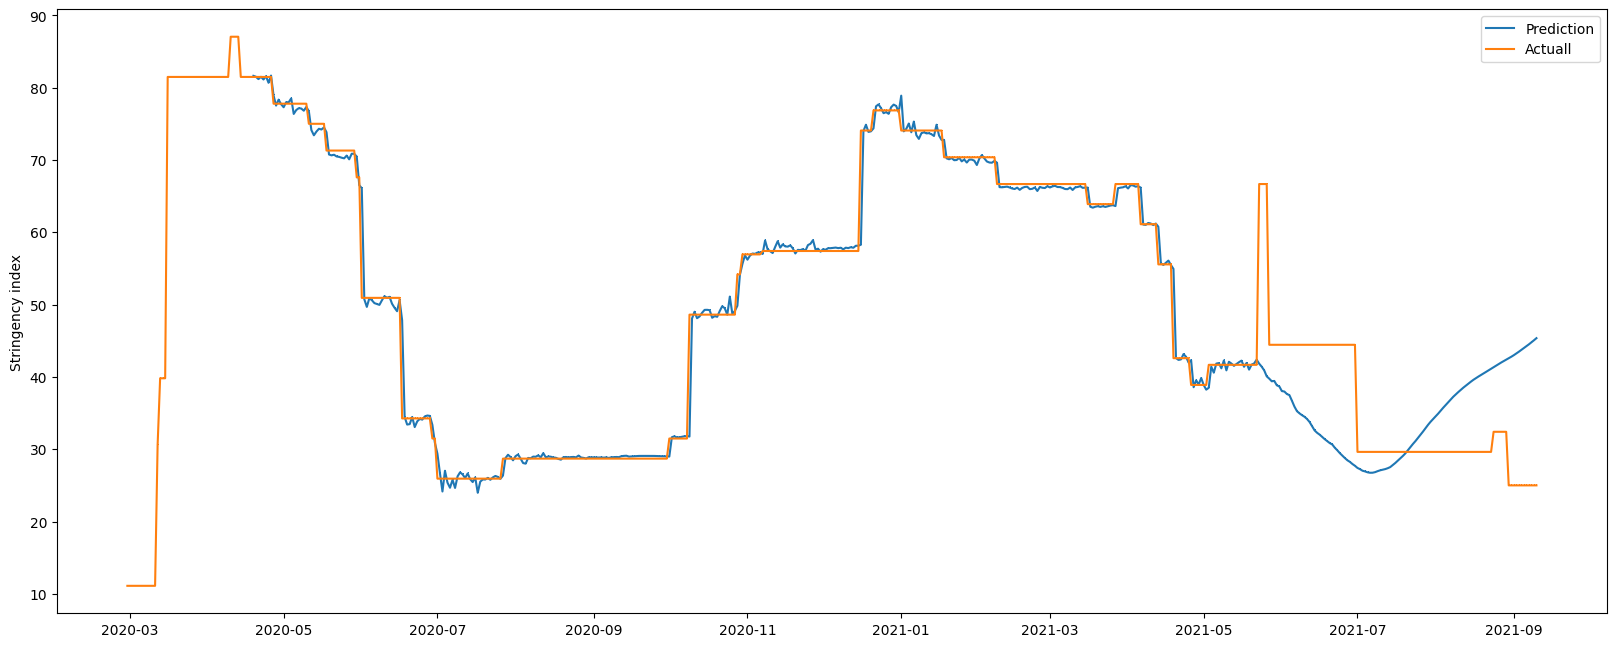

Training mse: 3.567111400411991 
Test mse: 126.05117700116274


In [69]:
lag = 50
res = AutoReg(train_df['stringency_index'], lags=lag, exog=train_df[['new_cases_smoothed', 'reproduction_rate']], trend='n').fit()
pred = res.predict(end=len(train_df)+len(test_df)-1, exog=train_df[['new_cases_smoothed', 'reproduction_rate']], exog_oos=test_df[['new_cases_smoothed', 'reproduction_rate']])

figure(figsize=(20, 8), dpi=100)

plt.plot_date(filtered_df['date'], pred, label='Prediction',linestyle='-', marker=',')
plt.plot_date(filtered_df['date'], filtered_df['stringency_index'], label='Actuall', linestyle='-', marker=',')
axes = plt.gca()
axes.set_ylabel('Stringency index')
plt.legend()
plt.show()

train_mse = calc_mse(pred[lag:len(train_df)], train_df['stringency_index'].to_numpy()[lag:])
test_mse = calc_mse(pred[len(train_df):], test_df['stringency_index'].to_numpy())
axes.set_ylabel('Stringency index')
print(f'Training mse: {train_mse} \nTest mse: {test_mse}')

Doing experiment like this is quite tedious, so lets spin up multiple cycles to do the meta-analysis for us.

C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be g

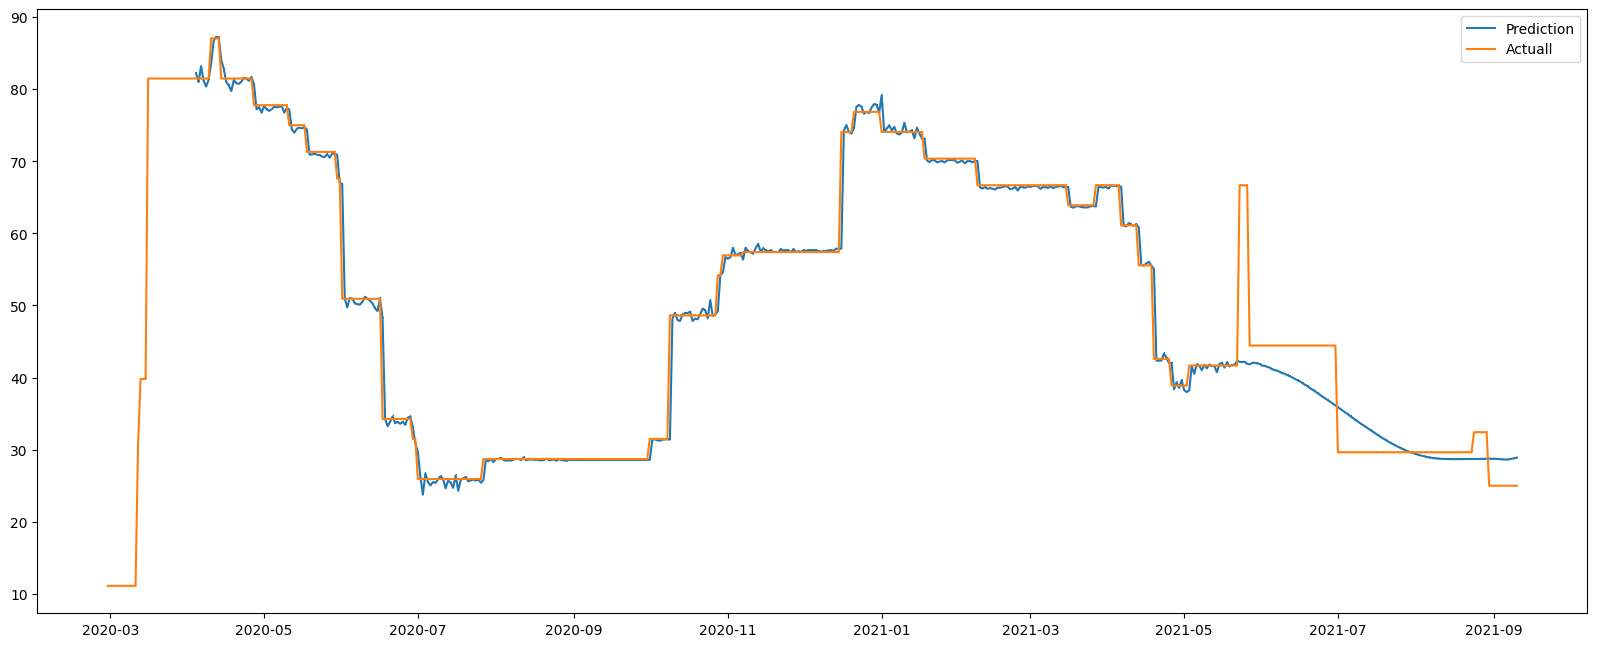

{'lag': 35, 'exog params': array(['new_cases_smoothed', 'hosp_patients', 'new_deaths_smoothed'],
      dtype='<U19'), 'trend': 'n'}
35.25289764811163


In [48]:

best_config = {}
best_mse = -1
best_predictions = []
possible_trends = ['n', 'c', 't', 'ct']
possible_exog = ['new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']
exog_combinations = []
for L in range(0, len(possible_exog)+1):
    for subset in itertools.combinations(possible_exog, L):
        exog_combinations.append(np.asarray(subset))

for lag in range(5, 100, 5):
    for exog_params in exog_combinations:
        for trend in possible_trends:
            if len(exog_params) > 1:
                res = AutoReg(train_df['stringency_index'], lags=lag, exog=train_df[exog_params], trend=trend).fit()
                pred = res.predict(end=len(train_df)+len(test_df)-1, exog=train_df[exog_params], exog_oos=test_df[exog_params])
            else:
                res = AutoReg(train_df['stringency_index'], lags=lag, trend=trend).fit()
                pred = res.predict(end=len(train_df)+len(test_df)-1)
    
            test_mse = calc_mse(pred[len(train_df):], test_df['stringency_index'].to_numpy())
            if best_mse == -1 or best_mse > test_mse:
                best_mse = test_mse
                best_config['lag'] = lag
                best_config['exog params'] = exog_params
                best_config['trend'] = trend
                best_predictions = pred


figure(figsize=(20, 8), dpi=100)
plt.plot_date(filtered_df['date'], best_predictions, label='Prediction',linestyle='-', marker=',')
plt.plot_date(filtered_df['date'], filtered_df['stringency_index'], label='Actuall', linestyle='-', marker=',')
plt.legend()
plt.show()

print(best_config)
print(best_mse)

In [96]:
filtered_df = df[df['location'] == 'Lithuania'][['date', 'location', 'stringency_index', 'new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']].sort_values('date', ascending=True)
filtered_df = cutoff_latest(filtered_df).dropna()
train_df, test_df = train_test_split(filtered_df)

C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(
C:\Users\meop\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590

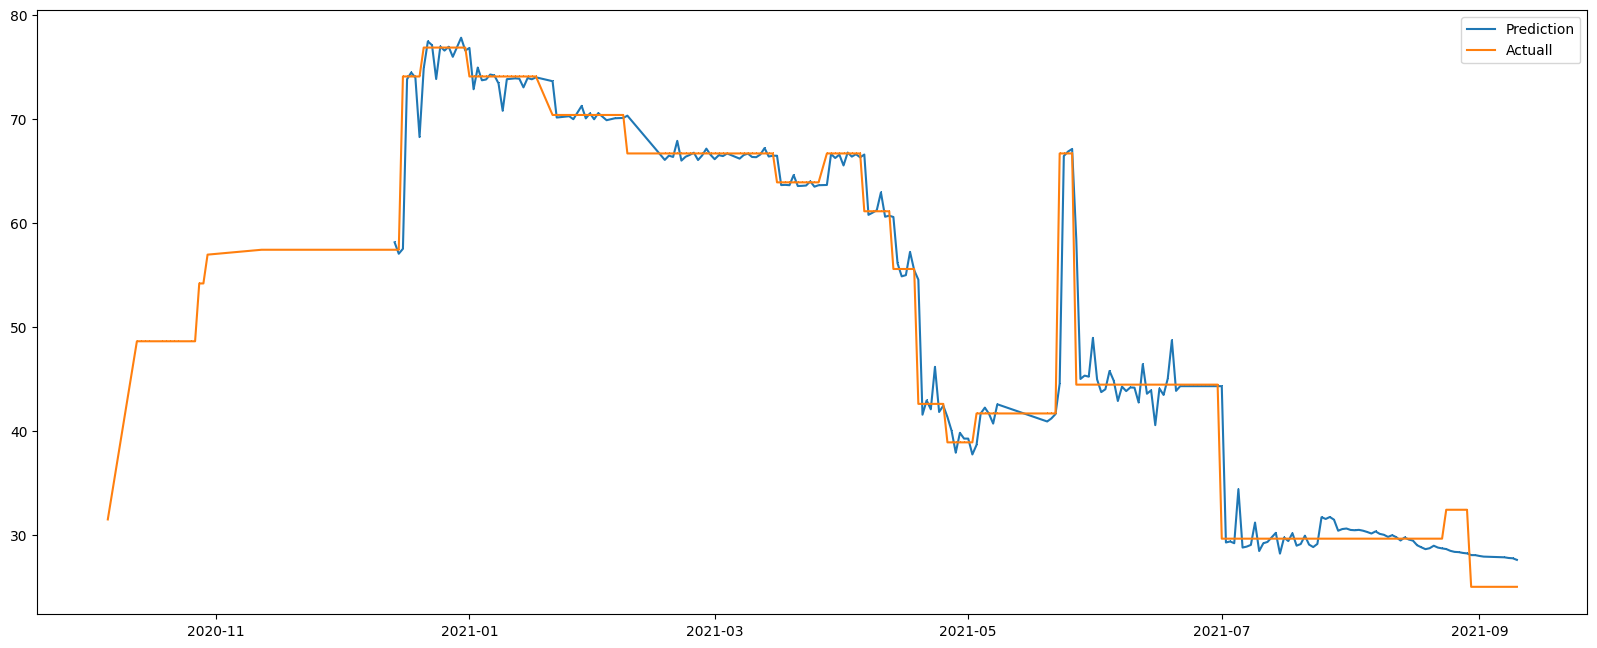

{'lag': 25, 'exog params': array([], dtype=float64), 'trend': 'n'}
3.7165527605859427


In [73]:
best_config = {}
best_mse = -1
best_predictions = []
possible_trends = ['n', 'c', 't', 'ct']
possible_exog = ['new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']
exog_combinations = []
for L in range(0, len(possible_exog)+1):
    for subset in itertools.combinations(possible_exog, L):
        exog_combinations.append(np.asarray(subset))

for lag in range(5, 100, 5):
    for exog_params in exog_combinations:
        for trend in possible_trends:
            if len(exog_params) > 1:
                res = AutoReg(train_df['stringency_index'], lags=lag, exog=train_df[exog_params], trend=trend).fit()
                pred = res.predict(end=len(train_df)+len(test_df)-1, exog=train_df[exog_params], exog_oos=test_df[exog_params])
            else:
                res = AutoReg(train_df['stringency_index'], lags=lag, trend=trend).fit()
                pred = res.predict(end=len(train_df)+len(test_df)-1)
    
            test_mse = calc_mse(pred[len(train_df):], test_df['stringency_index'].to_numpy())
            if best_mse == -1 or best_mse > test_mse:
                best_mse = test_mse
                best_config['lag'] = lag
                best_config['exog params'] = exog_params
                best_config['trend'] = trend
                best_predictions = pred


figure(figsize=(20, 8), dpi=100)
plt.plot_date(filtered_df['date'], best_predictions, label='Prediction',linestyle='-', marker=',')
plt.plot_date(filtered_df['date'], filtered_df['stringency_index'], label='Actuall', linestyle='-', marker=',')
plt.legend()
plt.show()

print(best_config)
print(best_mse)

In [97]:
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

42.57467445207155


<AxesSubplot:xlabel='date'>

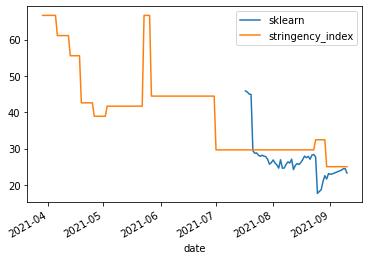

In [98]:
linear_regression = get_sklearn_wrapper(svm.LinearSVR)

date_indexed_train_df = train_df.set_index('date')
date_indexed_test_df = test_df.set_index('date')
date_indexed_filtered_df = filtered_df.set_index('date')

pred = (linear_regression.fit(date_indexed_train_df[['new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']], date_indexed_train_df['stringency_index'])
                  .predict(date_indexed_test_df[['new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']]))

svm_mse = calc_mse(pred['sklearn'].to_numpy(), date_indexed_test_df['stringency_index'])
print(svm_mse)

pred.merge(date_indexed_filtered_df['stringency_index'], left_index=True, right_index=True, how='outer').tail(150).plot()



596.6085185785097


<AxesSubplot:xlabel='date'>

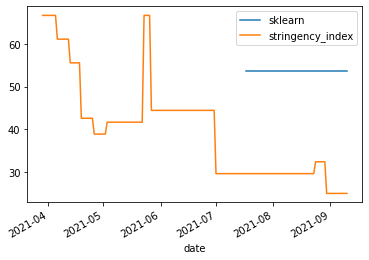

In [99]:
linear_regression = get_sklearn_wrapper(RandomForestRegressor, n_estimators=100, min_samples_split=.7)

date_indexed_train_df = train_df.set_index('date')
date_indexed_test_df = test_df.set_index('date')
date_indexed_filtered_df = filtered_df.set_index('date')

pred = (linear_regression.fit(date_indexed_train_df[['new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']], date_indexed_train_df['stringency_index'])
                  .predict(date_indexed_test_df[['new_cases_smoothed', 'reproduction_rate', 'hosp_patients', 'new_deaths_smoothed']]))

forrest_mse = calc_mse(pred['sklearn'].to_numpy(), date_indexed_test_df['stringency_index'])
print(forrest_mse)

pred.merge(date_indexed_filtered_df['stringency_index'], left_index=True, right_index=True, how='outer').tail(150).plot()


<a id='Q3Conclusion' name='Q3Conclusion'></a>
## Conclusion

1. Removing NAN rows gave some interesting results, while it seems the model became more accurate, the remaining test data was left without any huge slopes, making it easier to guess
2. Accurately guessing Lithuanias stringency index is quite difficult.
3. From the selected models it seems AutoReg was the best performing one 

[back to the top](#main)